<a href="https://colab.research.google.com/github/imakshatt/Deep-Learning-Concepts/blob/main/Quantization_with_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use MNIST in LeNet5 model

In [1]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings('ignore')
import os

In [3]:
print(torch.__version__)

2.4.0+cu121


In [4]:
torch.cuda.is_available()


True

In [5]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.quant = torch.ao.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(16*4*4, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 10)
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = self.relu2(x)
        x = F.max_pool2d(x, 2)
        x = x.reshape(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        x = self.dequant(x)
        return x



In [6]:
model = LeNet5()
print(model)

LeNet5(
  (quant): QuantStub()
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dequant): DeQuantStub()
)


In [7]:
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p")
    print("Model: ", label, ' \t', 'Size (KB):', size/1e3)
    os.remove('temp.p')
    return size


In [8]:
#to convert to tensor and Normalizing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [9]:
trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15403112.37it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 478712.06it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4397505.79it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4577253.43it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



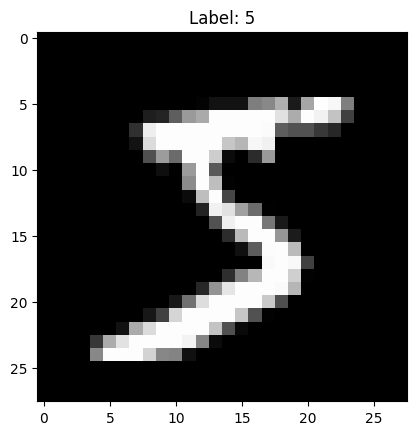

In [10]:
import matplotlib.pyplot as plt
import torchvision
import torch

image, label = trainset[0]

# Convert the image tensor to a NumPy array and display it
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()


In [11]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size = 32,
    shuffle = True
)

In [12]:
testset = torchvision.datasets.MNIST(
    root = './data',
    train=False,
    download=True,
    transform=transform
)

In [13]:
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size = 32,
    shuffle=False
)

In [ ]:

fp32_model = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fp32_model.parameters(), lr=0.001, momentum=0.9)

# Train the model for 5 epochs
for epoch in range(5):
    for i, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()           # Clear previous gradients
        outputs = fp32_model(inputs)    # Forward pass: compute predictions
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                 # Backward pass: compute gradients
        optimizer.step()                # Update model parameters

        # Print loss every 200 batches
        if (i + 1) % 200 == 0:
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item()}')

print('Finished Training FP32 Model')


Epoch 1, Batch 200, Loss: 2.265826463699341
Epoch 1, Batch 400, Loss: 2.1970012187957764
Epoch 1, Batch 600, Loss: 0.7098519206047058
Epoch 1, Batch 800, Loss: 0.5250412225723267
Epoch 1, Batch 1000, Loss: 0.3957173824310303
Epoch 1, Batch 1200, Loss: 0.19206924736499786
Epoch 1, Batch 1400, Loss: 0.11562684923410416
Epoch 1, Batch 1600, Loss: 0.11242236196994781
Epoch 1, Batch 1800, Loss: 0.25965917110443115
Epoch 2, Batch 200, Loss: 0.05628267675638199
Epoch 2, Batch 400, Loss: 0.16401444375514984
Epoch 2, Batch 600, Loss: 0.13989506661891937
Epoch 2, Batch 800, Loss: 0.141544371843338
Epoch 2, Batch 1000, Loss: 0.2874557375907898
Epoch 2, Batch 1200, Loss: 0.09116841107606888
Epoch 2, Batch 1400, Loss: 0.07637503743171692
Epoch 2, Batch 1600, Loss: 0.17604143917560577
Epoch 2, Batch 1800, Loss: 0.21454080939292908
Epoch 3, Batch 200, Loss: 0.040130600333213806
Epoch 3, Batch 400, Loss: 0.11877137422561646
Epoch 3, Batch 600, Loss: 0.1333910971879959
Epoch 3, Batch 800, Loss: 0.06571

Epoch 1, Loss: 1.1954, Avg Gradients: 0.127031
Epoch 2, Loss: 0.1488, Avg Gradients: 0.120065
Epoch 3, Loss: 0.1000, Avg Gradients: 0.099493
Epoch 4, Loss: 0.0794, Avg Gradients: 0.088480
Epoch 5, Loss: 0.0677, Avg Gradients: 0.079723
Finished Training FP32 Model


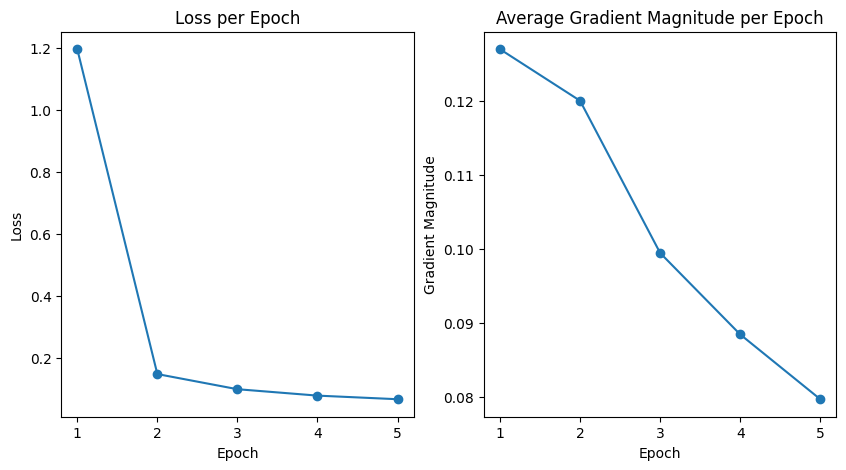

In [14]:
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# Initialize lists to track losses and gradients
epoch_losses = []
epoch_gradients = []

# Train the FP32 model
fp32_model = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fp32_model.parameters(), lr=0.001, momentum=0.9)

# Train for 5 epochs and track loss and gradient magnitude
for epoch in range(5):
    running_loss = 0.0
    total_gradients = 0.0

    for i, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()  # Clear previous gradients
        outputs = fp32_model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        loss.backward()  # Backward pass (compute gradients)

        # Track gradient magnitudes to detect vanishing/exploding gradients
        total_grads = 0.0
        for param in fp32_model.parameters():
            if param.grad is not None:
                total_grads += param.grad.abs().mean().item()  # Mean gradient magnitude

        total_gradients += total_grads
        optimizer.step()  # Update model parameters

        running_loss += loss.item()

    # Calculate the average loss and gradients for this epoch
    epoch_loss = running_loss / len(trainloader)
    avg_gradients = total_gradients / len(trainloader)

    # Store for visualization
    epoch_losses.append(epoch_loss)
    epoch_gradients.append(avg_gradients)

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Avg Gradients: {avg_gradients:.6f}')

print('Finished Training FP32 Model')

# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), epoch_losses, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot the gradient magnitudes curve
plt.subplot(1, 2, 2)
plt.plot(range(1, 6), epoch_gradients, marker='o')
plt.title('Average Gradient Magnitude per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Gradient Magnitude')

plt.show()


In [15]:
dynamic_quantized_model = torch.quantization.quantize_dynamic(
    fp32_model,
    {torch.nn.Linear},
    dtype=torch.qint8
)

In [16]:
Static_Quant_Model = LeNet5()
#Static_Quant_Model = Static_Quant_Model.to('cuda')
inputs = inputs.to('cuda')

labels = labels.to('cuda')


In [17]:
labels.is_cuda

True

In [18]:
from torch.utils.data import DataLoader, Subset
import numpy as np

# Use a subset of the training dataset for calibration
calibration_indices = np.random.choice(len(trainset), size=5000, replace=False)
calibration_subset = Subset(trainset, calibration_indices)
calibration_loader = DataLoader(calibration_subset, batch_size=32, shuffle=False)


In [19]:
Static_Quant_Model.eval()

Static_Quant_Model.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')

model_fp32_fused = torch.ao.quantization.fuse_modules(Static_Quant_Model,
    [['conv1', 'relu1'], ['conv2', 'relu2']])

model_fp32_prepared = torch.ao.quantization.prepare(model_fp32_fused)

model_fp32_prepared.eval()
with torch.no_grad():
    for i, (images, _) in enumerate(calibration_loader):
      if i > 50:
        break
    model_fp32_prepared(images)

Static_Quantized_Model = torch.ao.quantization.convert(model_fp32_prepared)


# res = Static_Quantized_Model(input_fp32)

In [20]:
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [21]:
fp32_model_accuracy = evaluate_model(fp32_model, testloader)
dynamic_quantized_model_accuracy = evaluate_model(dynamic_quantized_model, testloader)
Static_quantized_model_accuracy = evaluate_model(Static_Quantized_Model, trainloader)

In [22]:
print(f'FP32 Model Accuracy: {fp32_model_accuracy}%')
print(f'Dynamic Model Accuracy: {dynamic_quantized_model_accuracy}%')
print(f'Static Model Accuracy: {Static_quantized_model_accuracy}%')

FP32 Model Accuracy: 98.1%
Dynamic Model Accuracy: 98.07%
Static Model Accuracy: 10.073333333333334%


In [ ]:
# def evaluate_model(model, testloader):
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for data in testloader:
#             images, labels = data
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#     accuracy = 100 * correct / total
#     return accuracy

# fp32_accuracy = evaluate_model(fp32_model, testloader)
# dynamic_quantized_accuracy = evaluate_model(dynamic_quantized_model, testloader)
# Static_quantized_accuracy = evaluate_model(Static_Quantized_Model, testloader)

# print(f'FP32 Model Accuracy: {fp32_accuracy}%')
# print(f'Dynamic Quantized Model Accuracy: {dynamic_quantized_accuracy}%')
# print(f'Static Quantized Model Accuracy: {Static_quantized_accuracy}%')

FP32 Model Accuracy: 98.29%
Dynamic Quantized Model Accuracy: 98.32%
Static Quantized Model Accuracy: 9.8%


In [23]:
fp32_model_size = print_size_of_model(fp32_model, "FP32")
quantized_model_size = print_size_of_model(dynamic_quantized_model, "INT8")
Static_quantized_model_size = print_size_of_model(Static_Quant_Model, "INT8")

Model:  FP32  	 Size (KB): 181.006
Model:  INT8  	 Size (KB): 58.09
Model:  INT8  	 Size (KB): 181.006


FP32 Model Classification:


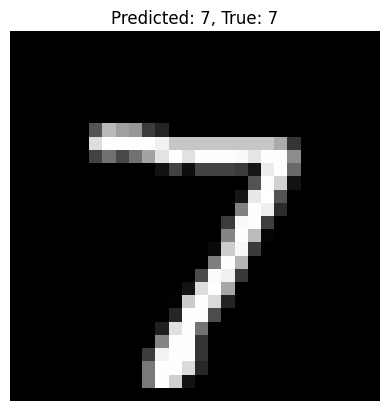

Quantized Model Classification:


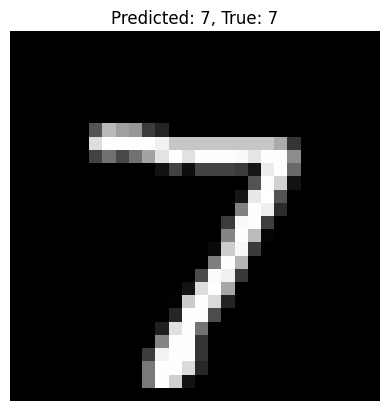

In [ ]:
import matplotlib.pyplot as plt

def visualize_single_classification(model, testloader, image_index=54):

    dataiter = iter(testloader)
    images, labels = next(dataiter)


    image = images[image_index]
    label = labels[image_index]

    # Get the model's prediction
    output = model(image.unsqueeze(0))  # Add batch dimension
    _, predicted = torch.max(output, 1)

    # Plot the image with its predicted and true labels
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.title(f'Predicted: {predicted.item()}, True: {label.item()}')
    plt.axis('off')
    plt.show()

# Visualize a single image classification for the FP32 model
print("FP32 Model Classification:")
visualize_single_classification(fp32_model, testloader, image_index=0)

# Visualize a single image classification for the quantized model
print("Quantized Model Classification:")
visualize_single_classification(dynamic_quantized_model, testloader, image_index=0)
